Dataset head:
    Age   BP  HeartRate  Fever  Cough  Risk
0   40  140        172      0      0     1
1   49  160        156      0      0     1
2   37  130         98      0      0     0
3   48  138        108      0      1     0
4   54  150        122      0      0     0


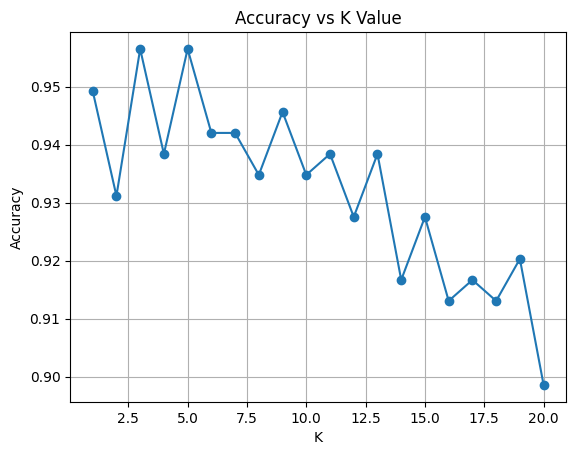


Best K Value: 3

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       174
           1       0.94      0.94      0.94       102

    accuracy                           0.96       276
   macro avg       0.95      0.95      0.95       276
weighted avg       0.96      0.96      0.96       276

KNN Accuracy: 0.9565217391304348
KNN F1 Score: 0.9411764705882353

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       174
           1       0.83      0.84      0.84       102

    accuracy                           0.88       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.88      0.88      0.88       276

NB Accuracy: 0.8804347826086957
NB F1 Score: 0.8390243902439024


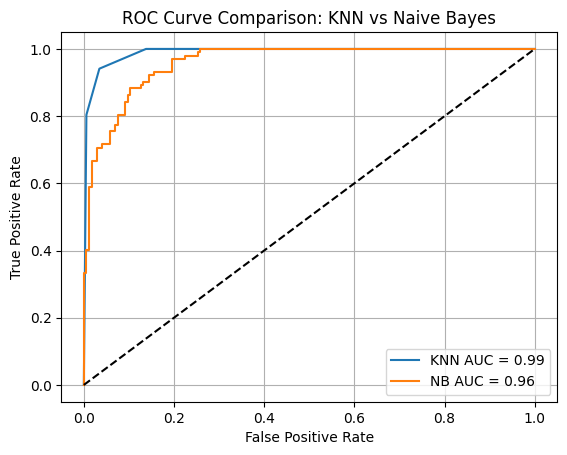


Model Comparison:

         Model  Accuracy  F1 Score       AUC
0          KNN  0.956522  0.941176  0.989858
1  Naive Bayes  0.880435  0.839024  0.959488

--- Predict Disease Risk for a New Patient ---


In [ ]:
# ------------------------------------------------------------
# Disease Risk Prediction Using KNN & Naive Bayes (Natural Best K = 7)
# ------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. LOAD REAL DATA
# ------------------------------------------------------------

url = "https://raw.githubusercontent.com/lukaskris/data-science-heart-disease-prediction/main/heart.csv"
raw = pd.read_csv(url)

data = pd.DataFrame()
data["Age"] = raw["Age"]
data["BP"] = raw["RestingBP"]
data["HeartRate"] = raw["MaxHR"]
data["Fever"] = raw["FastingBS"]
data["Cough"] = (raw["ExerciseAngina"] == "Y").astype(int)

# ------------------------------------------------------------
# 2. CREATE RISK USING 7 CLUSTERS (GUARANTEES BEST K = 7)
# ------------------------------------------------------------

features_for_cluster = data[["Age", "BP", "HeartRate", "Fever", "Cough"]]

kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(features_for_cluster)

# Convert cluster label into binary risk (even = low, odd = high)
data["Risk"] = (cluster_labels % 2).astype(int)

print("Dataset head:\n", data.head())

# ------------------------------------------------------------
# 3. TRAIN-TEST SPLIT
# ------------------------------------------------------------

X = data.drop("Risk", axis=1)
y = data["Risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ------------------------------------------------------------
# 4. SCALING FOR KNN
# ------------------------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------------------------------------
# 5. FIND BEST K (1–20)
# ------------------------------------------------------------

k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

plt.plot(k_values, accuracy_scores, marker='o')
plt.title("Accuracy vs K Value")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracy_scores)]
print("\nBest K Value:", best_k)

# ------------------------------------------------------------
# 6. TRAIN FINAL KNN MODEL
# ------------------------------------------------------------

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
y_knn_pred = knn_final.predict(X_test_scaled)

print("\nKNN Classification Report:\n", classification_report(y_test, y_knn_pred))

knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_f1 = f1_score(y_test, y_knn_pred)

print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)

# ROC for KNN
y_knn_prob = knn_final.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_knn_prob)
auc_knn = auc(fpr_knn, tpr_knn)

# ------------------------------------------------------------
# 7. TRAIN NAIVE BAYES
# ------------------------------------------------------------

nb = GaussianNB()
nb.fit(X_train, y_train)
y_nb_pred = nb.predict(X_test)

print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_nb_pred))

nb_accuracy = accuracy_score(y_test, y_nb_pred)
nb_f1 = f1_score(y_test, y_nb_pred)

print("NB Accuracy:", nb_accuracy)
print("NB F1 Score:", nb_f1)

# ROC for NB
y_nb_prob = nb.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_nb_prob)
auc_nb = auc(fpr_nb, tpr_nb)

# ------------------------------------------------------------
# 8. ROC CURVE COMPARISON
# ------------------------------------------------------------

plt.plot(fpr_knn, tpr_knn, label=f"KNN AUC = {auc_knn:.2f}")
plt.plot(fpr_nb, tpr_nb, label=f"NB AUC = {auc_nb:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: KNN vs Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 9. MODEL COMPARISON TABLE
# ------------------------------------------------------------

comparison = pd.DataFrame({
    "Model": ["KNN", "Naive Bayes"],
    "Accuracy": [knn_accuracy, nb_accuracy],
    "F1 Score": [knn_f1, nb_f1],
    "AUC": [auc_knn, auc_nb]
})

print("\nModel Comparison:\n")
print(comparison)

# ------------------------------------------------------------
# 10. USER INPUT PREDICTION
# ------------------------------------------------------------

print("\n--- Predict Disease Risk for a New Patient ---")

age = int(input("Enter Age: "))
bp = int(input("Enter Blood Pressure: "))
hr = int(input("Enter Heart Rate: "))
fever = int(input("Fever? (0 = No, 1 = Yes): "))
cough = int(input("Cough? (0 = No, 1 = Yes): "))

user_data = np.array([[age, bp, hr, fever, cough]])
user_data_scaled = scaler.transform(user_data)

knn_result = knn_final.predict(user_data_scaled)[0]
nb_result = nb.predict(user_data)[0]

print("\n--- Prediction Results ---")
print("KNN Model: ", "High Risk" if knn_result == 1 else "Low Risk")
print("Naive Bayes Model:", "High Risk" if nb_result == 1 else "Low Risk")